This script creates images to compare the cluster advantage between models

In [1]:
%pylab inline
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
from glob import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
RED, BLUE, GREEN = sns.xkcd_palette(["amber", "dusty purple", "faded green"])

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


In [3]:
GAMMA = 0.5772156649015328606065120900824024310421

def harmonic_number_(n):
	"""
		Returns the nth-harmonic number according to:
		sum_{i=1, @n} 1/i
		implemented as https://en.wikipedia.org/wiki/Harmonic_number#Calculation

	"""
	assert n>0, 'n must be bigger than 0'
	return GAMMA + np.log(n) + 0.5/n - 1./(12*n**2) + 1./(120*n**4)

def harmonic_number(n, power=1):
	"""
		Returns the nth-generalized 2nd order harmonic number according to:
		sum_{i=1, @n} 1/i^@power
		@TODO: is there a better way to do this?
	"""
	assert n>0, 'n must be bigger than 0'
	# use n+1 because arange doesn't include the n+1st integer.
	if power == 1 and n > 100: 
		return harmonic_number_(n)
	return np.sum(1./(np.arange(1,n+1)**power))



# Figure 4

In [6]:


def cluster_adv(ax, mappings, loglog=True):
    for mapping, color, model_name in zip(mappings, [RED, GREEN, BLUE], ['No Turnover', 'Surface Turnover', 'Turnover']):

        replicates = glob(mapping)

        all_ordered = []
        all_unordered = []
        for replicate_folder in replicates:
            try:
                S_ordered, S_unordered = glob(replicate_folder+'/Dec*/S_list*red.npy')
                S_ordered_loaded = np.load(S_ordered).astype(np.float)
                S_unordered_loaded = np.load(S_unordered).astype(np.float)
                if model_name in ['No Turnover', 'Turnover', 'Surface Turnover']:
                    S_ordered_loaded = S_ordered_loaded + 1
                    S_unordered_loaded = S_unordered_loaded + 1

        #         print S_ordered_loaded
                S_ordered_loaded = np.mean(S_ordered_loaded, axis=0)
        #         print S_ordered_loaded
                S_unordered_loaded = np.mean(S_unordered_loaded, axis=0)

                S_ordered_data = S_ordered_loaded/S_ordered_loaded[0]
                S_unordered_data = S_unordered_loaded/S_unordered_loaded[0]
                xaxis = np.arange(1,S_unordered_data.shape[0]+1)


                all_ordered.append(S_ordered_data)
                all_unordered.append(S_unordered_data)
            except Exception as e:
                print 'Exception: '+str(e)
                print 'Skipped Folder: '+str(glob(replicate_folder+'/Dec*/S_list*red.npy'))

    #     print all_ordered
        S_ordered_mean = np.mean(np.array(all_ordered),axis=0) - 1
        S_unordered_mean = np.mean(np.array(all_unordered), axis=0) - 1

        try: 
            xaxis = np.arange(1,S_ordered_mean.shape[0]+1)
            
            if loglog:
                ax.loglog(xaxis, S_ordered_mean, color=color, linestyle='--', label=model_name + ' (Cluster)')
                ax.loglog(xaxis, S_unordered_mean, color=color, linestyle='-', label=model_name + ' (Random Set)')
            else:
                ax.plot(xaxis, S_ordered_mean, color=color, linestyle='--', label=model_name + ' (Cluster)')
                ax.plot(xaxis, S_unordered_mean, color=color, linestyle='-', label=model_name + ' (Random Set)')
        except Exception as e:
            print 'skipped:'+str(e)
    if loglog:
        ax.loglog(xaxis, [(harmonic_number(n)+1)/float(harmonic_number(1)+1) - 1 for n in xaxis],':', color=(0,0,0,0.75), label='Standard Neutral Model')
    else:
        ax.plot(xaxis, [(harmonic_number(n)+1)/float(harmonic_number(1)+1) - 1 for n in xaxis],':', color=(0,0,0,0.75), label='Standard Neutral Model')
    ax.set_xlabel('CTC Cluster Size, $n$')
    ax.set_ylabel('Cluster Advantage, $\\frac{S(n)}{S(1)} - 1}$')
    sns.despine()



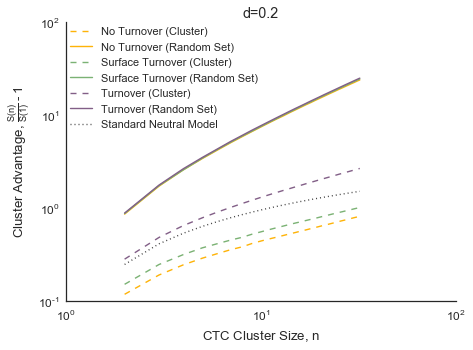

In [8]:
root_folder = '/Volumes/Stockage/u0.03simulations/'

death_rate = '02'
mappings = [ root_folder+'1_0_0_outs*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(111)
cluster_adv(ax, mappings)
ax.legend(loc=(0.0,0.6),fontsize=11)
# ax.set_xlim([10**0.25,10**1.5])
ax.set_title('d=0.'+death_rate[1:])


# plt.title('E[S(n)]/E[S(1)]')
f.savefig('cluster_advantage003.pdf')


# supplementary figure 4

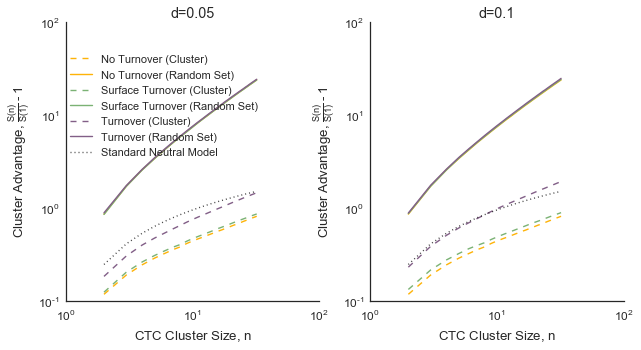

In [9]:
death_rate = '005'
root_folder = '/Volumes/Stockage/u0.03simulations/'
mappings = [ root_folder+'1_0_0_outs*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121)
cluster_adv(ax, mappings)
ax.legend(loc=(0,0.5),fontsize=11)

ax.set_title('d=0.'+death_rate[1:])

death_rate = '01'
mappings = [ root_folder+'1_0_0_outs*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']

ax = f.add_subplot(122)
cluster_adv(ax, mappings)

ax.set_title('d=0.'+death_rate[1:])


# plt.title('E[S(n)]/E[S(1)]')
f.savefig('cluster_advantage_supp.pdf')
